In [1]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True


# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
import vcf
import seaborn as sns
sns.set(style="ticks")

HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
DATAPATH="/storage/mgymrek/ssc-imputation/callstats/"
PCAFILE="/storage/s1saini/ssc-pca/pca_10.eigenvec"
ONEKGPOP="/home/mgymrek/workspace/ssc-imputation/denovos2/other_data/1000GenomesPopulations.csv"
SSCFAMS="/home/mgymrek/workspace/ssc-imputation/metadata/ssc_family_ids.txt"
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}

OUTPATH="pdfs/"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 500 # Min number of 1000G calls to include in heterozygosity comparison
NUMSAMPLES=1916

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load info

In [ ]:
locstats = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_locstats.tab"), sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)
locstats["length"] = locstats["end"]-locstats["start"]+1

In [ ]:
sampstats = pd.read_fwf(os.path.join(DATAPATH, "ssc_hipstr_sampstats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

In [ ]:
mend = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_mendstats.tab"), sep="\t", nrows=1000000)
mend["mend"] = mend["mend"].apply(int)
mend["chrom"] = mend["chrom"].apply(str)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
mend = mend[~mend["homref"]]
mend = pd.merge(mend, locstats[["chrom","start","end","FILTER"]], on=["chrom","start"])

# Figure 1B: Calls/sample

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25, alpha=0.5);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci (million)", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([(x)/10**6 for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(x=np.mean(sampstats["numloci"]), color="black", linestyle="dashed")
fig.savefig(os.path.join(OUTPATH, "Figure1_LociPerSample.pdf"))

In [ ]:
# Average calls/sample
np.mean(sampstats["numloci"])

# Figure 1C: Call rate per locus

In [ ]:
locstats_all = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats_all.ix[np.isnan(locstats_all["numcalls"]), "numcalls"] = 0
counts, bins = np.histogram(locstats["numcalls"], bins=25)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
# Merge with hipstr reference so we get loci with 0 calls
ax.bar(bins[:-1], np.log10(counts), color="black", width=(bins[1]-bins[0])/1.15, edgecolor="white", alpha=0.5);
ax.set_ylim(bottom=3.5, top=6);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(np.mean(locstats["numcalls"]), color="black", linestyle="dashed")
fig.savefig(os.path.join(OUTPATH, "Figure1_SamplesPerLocus.pdf"))

In [ ]:
# Overall call rate
1-locstats_all[locstats_all["numcalls"]==0].shape[0]/locstats_all.shape[0]

In [ ]:
# Average call rate
np.mean(locstats["numcalls"])/NUMSAMPLES

In [ ]:
# Loci remaining after filtering
locstats[locstats["FILTER"]=="."].shape[0]

# Figure 1D: Mendelian inheritance

In [ ]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.9, 1.1, 0.01)

mend_pass = mend[(mend["FILTER"]==".")]
mend_fail = mend[(mend["FILTER"]!=".")]

for period in range(1, 7):
    mend_scores_pass = []
    mend_scores_fail = []
    for q in scores:
        x_pass = mend_pass[(mend_pass["Q"]>=q) & (mend_pass["period"]==period)]
        if x_pass.shape[0] >= 50:
            mend_scores_pass.append(np.mean(x_pass["mend"]))
        else: mend_scores_pass.append(np.nan)
        x_fail = mend_fail[(mend_fail["Q"]>=q) & (mend_fail["period"]==period)]
        if x_fail.shape[0] >= 50:
            mend_scores_fail.append(np.mean(x_fail["mend"]))
        else: mend_scores_fail.append(np.nan)
    ax.plot(scores, mend_scores_pass, color=colors[period-1], marker="o");
    ax.plot(scores, mend_scores_fail, color=colors[period-1], linestyle="dashed");
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels(["%.2f"%(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.3f"%(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_MendelianInheritance.pdf"))

In [ ]:
# Average Mend. inheritance before filtering 
np.mean(mend_fail["mend"])

In [ ]:
# Average Mend. inheritance after filtering 
np.mean(mend_pass["mend"])

# Figure 1E: Comparison to lobSTR heterozygosities

In [ ]:
lobstr = pd.read_csv(os.path.join(DATAPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: str(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]
het = pd.merge(lobstr, locstats[["chrom","start","het","FILTER"]], on=["chrom","start"])
het = het[(het["FILTER"]==".") | (het["FILTER"]=="Het")]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(het["het_lobstr"], het["het"], color="black", alpha=0.01);
ax.plot([0,1],[0,1], linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Heterozygosity - 1000G", size=15)
ax.set_ylabel("Heterozygosity - SSC", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_Heterozygosities.png"))

In [ ]:
# Correlation with lobSTR heterozygosities - TODO
r, p = scipy.stats.pearsonr(het["het_lobstr"], het["het"])
print("\t".join([str(item) for item in [r, p, het.shape[0]]]))

# Supplemental Figure: SSC Populations

In [ ]:
# Load PCA results
pca = pd.read_csv(PCAFILE, sep=" ",
                 names=["sample","sample2"]+["pc%s"%i for i in range(1,11)])
# Load 1kg population labels
onekg = pd.read_csv(ONEKGPOP)

# Load pedigree info
ped = pd.read_csv(SSCFAMS, sep="\t", names=["id","sample"])
ped["family"] = ped["id"].apply(lambda x: x.split(".")[0])
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])

# Merge final data
data = pd.merge(pca, onekg, on="sample", how="left")
data = pd.merge(data, ped[["family","rel","sample"]], on="sample", how="left")


refdata = data[(data["Population"].apply(lambda x: str(x) != "nan"))]
refdata["color"] = refdata.apply(lambda x: POPCOLORS.get(x["Superpop"],"gray"), 1)
ssc = data[(data["Population"].apply(lambda x: str(x) == "nan"))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ssc["pc1"], ssc["pc2"], color="black", s=2);
ax.scatter(refdata["pc1"], refdata["pc2"], color=list(refdata["color"]), s=5);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15);
fig.savefig(os.path.join(OUTPATH, "SuppFig_PopPCA.pdf"));

# Supplemental Figure: Length bias

In [ ]:
reflen = range(10, 100, 1)
diffs = []
percs = []
for i in range(len(reflen)-1):
    lb = reflen[i]
    ub = reflen[i+1]
    x = locstats[(locstats["length"]>=lb) & (locstats["length"]<ub)]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else:
        diffs.append(sum(x.apply(lambda x: x["mean_allele"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<ub].shape[0]*1.0/locstats.shape[0])

In [ ]:
xmax = 100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen[:-1], diffs, color="black", s=7);
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Median Deviation (bp)", size=15)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=10, right=xmax)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")

ax2 = ax.twinx()
ax2.plot(reflen[:-1], percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=xmax)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax2.axvline(x=40, linestyle="dashed", color="gray")
fig.savefig(os.path.join(OUTPATH, "SuppFig_LengthBias.pdf"));

# Figure 1e - TP vs Hip AF

In [5]:
hipstr_to_tp_id = {"Expansion_ATN1/DRPLA":"DRPLA",
"Expansion_SCA2/ATXN2":"SCA2",
"Expansion_SCA8/ATXN8":"SCA8",
"Expansion_SCA3_MJD/ATXN3":"SCA3",
"Expansion_HDL2/JPH3":"HDL",
"Expansion_DM1/DMPK":"DM1",
"Expansion_SCA1/ATXN1":"SCA1",
"Expansion_SCA12/PPP2R2B":"SCA12",
"Expansion_SCA7/ATXN7":"SCA7"}

hipstr_loci = [('12', 7045880),
('12', 112036754),
('13', 70713484),
('14', 92537353),
('16', 87637889),
('19', 46273457),
('6', 16327865),
('5', 146258291),
('3', 63898361)]

In [16]:
control_size = 307
cag_size = 3
control_sca1 = [29]*int(0.06*307) + [30]*int(0.31*307) + [31]*int(0.37*307) + [32]*int(0.09*307) + [33]*int(0.09*307) + [34]*int(0.03*307) + [35]*int(0.02*307)
control_sca2 = [22]*int(0.89*307) + [23]*int(0.09*307)
control_sca3 = [14]*int(0.24*307) + [20]*int(0.06*307) + [21]*int(0.09*307) + [22]*int(0.02*307) + [23]*int(0.26*307) + [24]*int(0.06*307) + [26]*int(0.02*307) + [27]*int(0.16*307) + [28]*int(0.04*307) 
control_sca6 = [7]*int(0.075*307) + [11]*int(0.37*307) + [12]*int(0.19*307) + [13]*int(0.32*307) + [14]*int(0.04*307)
#control_sca4 = [10]*int(0.76*307) + [11]*int(0.04*307) + [12]*int(0.14*307) + [13]*int(0.06*307)
#control_sca10 = [10]*int(0.02*307) + [11]*int(0.09*307) + [12]*int(0.27*307) + [13]*int(0.29*307) + [14]*int(0.16*307) + [15]*int(0.08*307) + [16]*int(0.05*307) + [17]*int(0.02*307) + [18]*int(0.02*307)
control_sca12 = [9]*int(0.02*307) + [10]*int(0.59*307) + [11]*int(0.01*307)  + [13]*int(0.11*307) + [14]*int(0.09*307) + [15]*int(0.15*307) + [16]*int(0.01*307) + [18]*int(0.02*307)
control_sca17 = [30]*int(0.02*307) + [33]*int(0.06*307) + [34]*int(0.15*307)  + [35]*int(0.26*307) + [36]*int(0.41*307) + [37]*int(0.06*307) + [38]*int(0.01*307)
control_sca8 = [18]*int(0.16*307) + [19]*int(0.02*307) + [21]*int(0.01*307)  + [23]*int(0.23*307) + [24]*int(0.10*307) + [25]*int(0.13*307) + [26]*int(0.11*307) + [27]*int(0.08*307)  + [28]*int(0.06*307) + [29]*int(0.04*307) + [30]*int(0.02*307) + [32]*int(0.01*307)
control_drpla = [8]*int(0.12*307) + [10]*int(0.11*307) + [11]*int(0.01*307)  + [12]*int(0.02*307) + [13]*int(0.01*307) + [14]*int(0.04*307) + [15]*int(0.37*307) + [16]*int(0.20*307)  + [17]*int(0.07*307) + [18]*int(0.01*307) + [19]*int(0.02*307) + [20]*int(0.02*307)


sca1_length = 87
sca2_length = 69
sca3_length = 24
sca6_length = 39
#sca4_length = 0
#sca10_length = 24
sca12_length = 30
sca17_length = 114
sca8_length = 45
drpla_length = 45

In [17]:
def returnAFDF(locus, algo, af):
    return pd.DataFrame({'locus':[locus]*len(af), 'algorithm':[algo]*len(af), 'allele':af})

In [18]:
afData = pd.DataFrame()

vcf_reader = vcf.Reader(filename='/storage/s1saini/manuscript_strsnp/fig3/tredparse_calls/tredparse.output_gt.vcf.gz')
for record in vcf_reader:
    allele_list = []
    num_called = (record.num_called)
    aaf = dict(zip([len(x) for x in record.ALT],record.aaf))
    aaf[len(record.REF)] = 1-np.sum(record.aaf)
    for x in aaf:
        allele_list = allele_list + [x-len(record.REF)]*int(aaf[x]*num_called*2)
    afData = pd.concat([afData, returnAFDF(record.ID, "TredParse", allele_list)])
    

for hip_locus in hipstr_loci:
    file = '/storage/s1saini/hipstr_rerun/chr'+hip_locus[0]+'/hipstr.chr'+hip_locus[0]+'.with.1kg.filtered.vcf.gz'
    vcf_reader = vcf.Reader(filename=file)
    for record in vcf_reader.fetch(hip_locus[0], hip_locus[1]-1, hip_locus[1]+1):
        allele_list = []
        num_called = (record.num_called)
        aaf = dict(zip([len(x) for x in record.ALT],record.aaf))
        aaf[len(record.REF)] = 1-np.sum(record.aaf)
        for x in aaf:
            allele_list = allele_list + [x-len(record.REF)]*int(aaf[x]*num_called*2)
        afData = pd.concat([afData, returnAFDF(hipstr_to_tp_id[record.ID], "HipSTR", allele_list)])

In [19]:
afData = pd.concat([afData, returnAFDF("SCA1", "Control", [x*3-sca1_length for x in control_sca1])])
afData = pd.concat([afData, returnAFDF("SCA2", "Control", [x*3-sca2_length for x in control_sca2])])
afData = pd.concat([afData, returnAFDF("SCA3", "Control", [x*3-sca3_length for x in control_sca3])])
afData = pd.concat([afData, returnAFDF("SCA6", "Control", [x*3-sca6_length for x in control_sca6])])
afData = pd.concat([afData, returnAFDF("SCA12", "Control", [x*3-sca12_length for x in control_sca12])])
afData = pd.concat([afData, returnAFDF("SCA17", "Control", [x*3-sca17_length for x in control_sca17])])
afData = pd.concat([afData, returnAFDF("SCA8", "Control", [x*3-sca8_length for x in control_sca8])])
afData = pd.concat([afData, returnAFDF("DRPLA", "Control", [x*3-drpla_length for x in control_drpla])])

In [13]:
common_loci = afData[afData['locus'].isin(list(set(afData[afData.algorithm=="HipSTR"].locus.values)))]

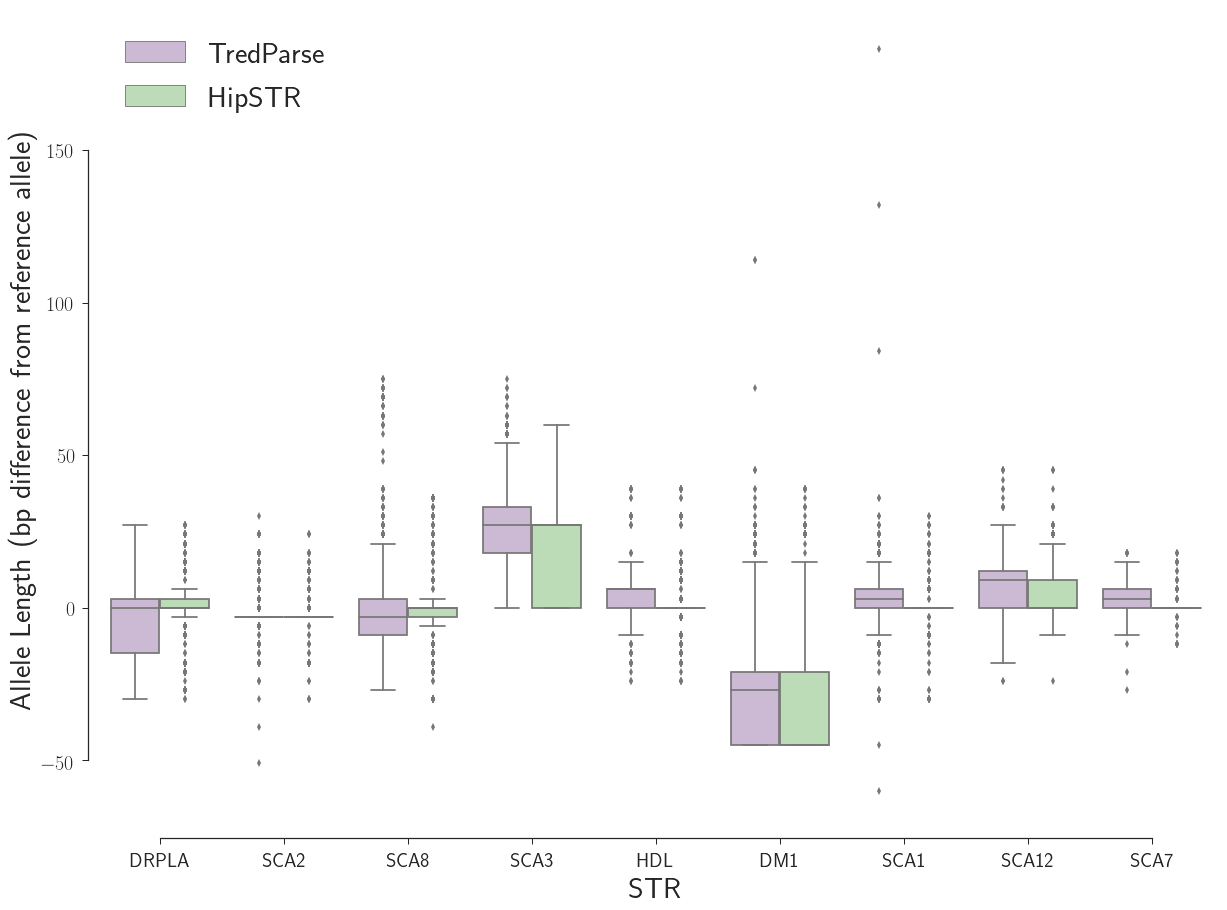

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

sns.boxplot(x="locus", y="allele", hue="algorithm", data=common_loci, palette="PRGn")
#ax = sns.swarmplot(x="locus", y="allele", hue="algorithm", data=afData, palette="PRGn", dodge=True,linewidth=1,edgecolor='gray')

#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:np.unique(afData.algorithm).shape[0]], labels[0:np.unique(afData.algorithm).shape[0]], bbox_to_anchor=(1.05, 1), borderaxespad=0.)

sns.despine(offset=10, trim=True)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_xlabel("STR", size=30);
ax.set_ylabel("Allele Length (bp difference from reference allele)", size=30);

ax.legend(loc="upper left", prop={'size': 30})

fig.savefig(os.path.join(OUTPATH, "tp_vs_hipstr_af.pdf"))

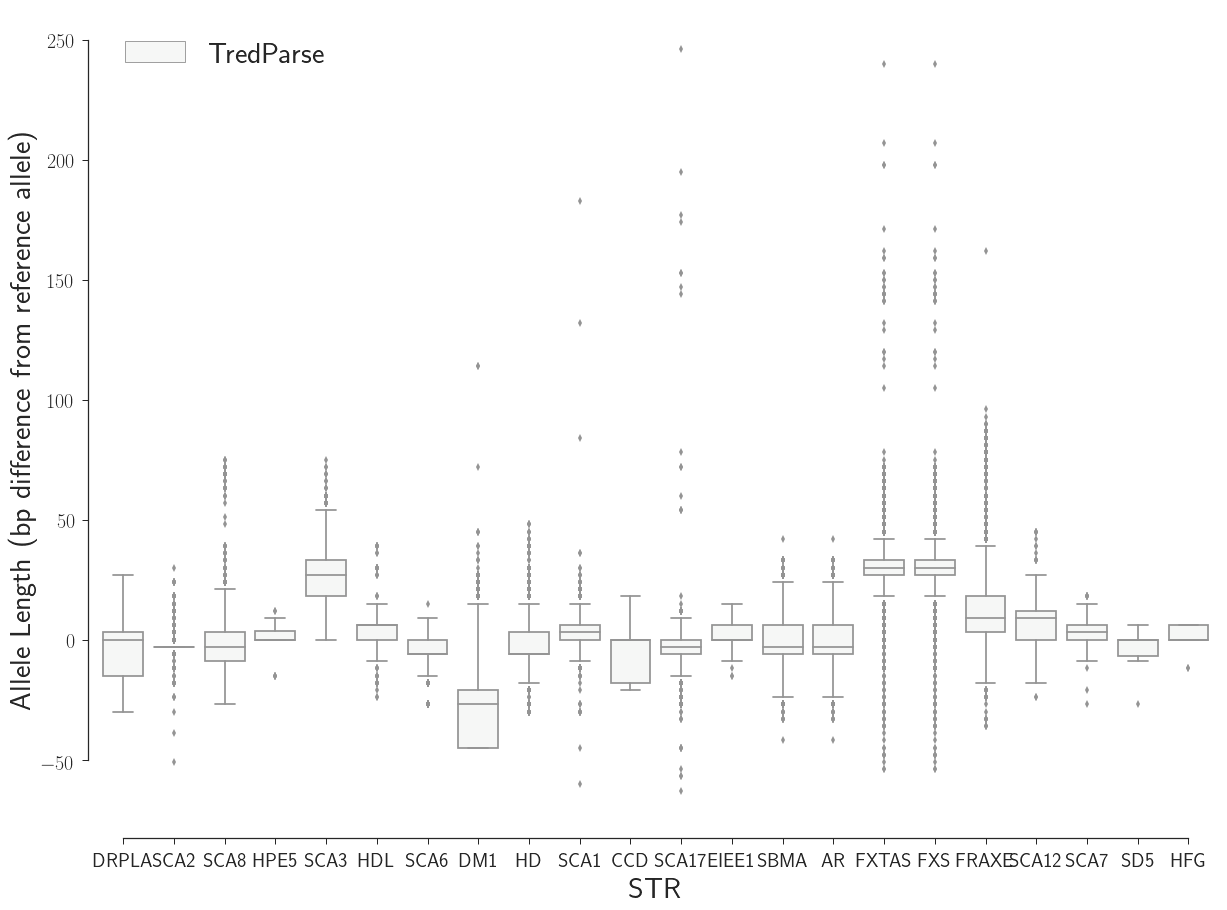

In [17]:
tp_freq = afData[afData['algorithm']=="TredParse"]

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

sns.boxplot(x="locus", y="allele", hue="algorithm", data=tp_freq, palette="PRGn")
#ax = sns.swarmplot(x="locus", y="allele", hue="algorithm", data=afData, palette="PRGn", dodge=True,linewidth=1,edgecolor='gray')

#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:np.unique(afData.algorithm).shape[0]], labels[0:np.unique(afData.algorithm).shape[0]], bbox_to_anchor=(1.05, 1), borderaxespad=0.)

sns.despine(offset=10, trim=True)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_xlabel("STR", size=30);
ax.set_ylabel("Allele Length (bp difference from reference allele)", size=30);

ax.legend(loc="upper left", prop={'size': 30})

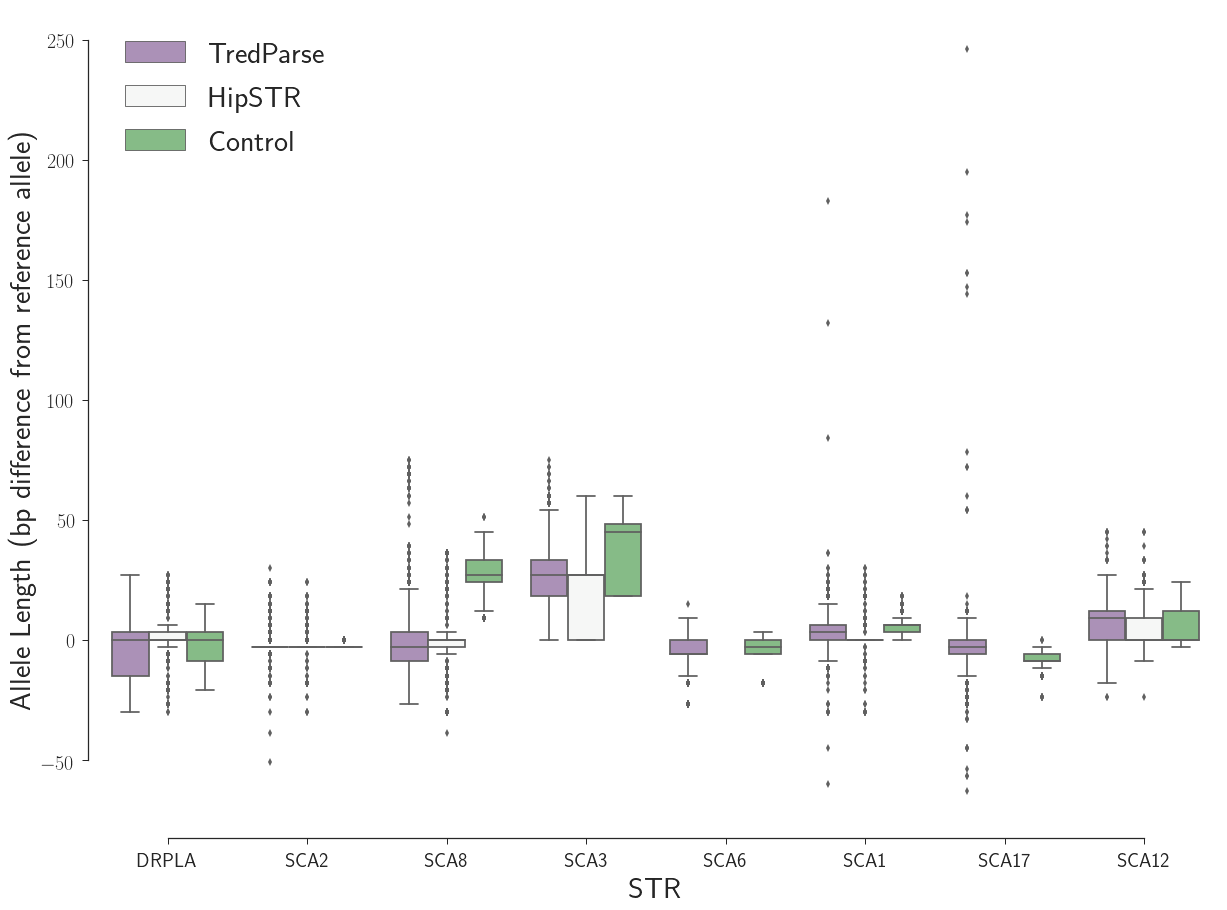

In [20]:
control_loci = afData[afData['locus'].isin(list(set(afData[afData.algorithm=="Control"].locus.values)))]

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

sns.boxplot(x="locus", y="allele", hue="algorithm", data=control_loci, palette="PRGn")
#ax = sns.swarmplot(x="locus", y="allele", hue="algorithm", data=afData, palette="PRGn", dodge=True,linewidth=1,edgecolor='gray')

#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:np.unique(afData.algorithm).shape[0]], labels[0:np.unique(afData.algorithm).shape[0]], bbox_to_anchor=(1.05, 1), borderaxespad=0.)

sns.despine(offset=10, trim=True)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_xlabel("STR", size=30);
ax.set_ylabel("Allele Length (bp difference from reference allele)", size=30);

ax.legend(loc="upper left", prop={'size': 30})